In [137]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage

from sklearn import metrics
from sklearn.metrics import confusion_matrix

from keras import models
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

# Designing the model

In [7]:
train_dir = '../../src/data/train'
validation_dir = '../../src/data/val'
test_dir = '../../src/data/test'

In [14]:
# Your code here; design and compile the model
dagenerator = ImageDataGenerator(rescale=1./255)
target_size = (64, 64)
batch_size = 10
num_of_train_samples = 4101
num_of_val_samples = 600



train_generator = dagenerator.flow_from_directory(
        train_dir,
        target_size= target_size, 
        batch_size = batch_size, 
        color_mode="rgb")

val_generator = dagenerator.flow_from_directory(
        validation_dir,
        target_size= target_size, 
        batch_size = batch_size,
        color_mode="rgb")

test_generator = dagenerator.flow_from_directory(
        test_dir,
        target_size= target_size, 
        batch_size = test_size, #All images in test set
        class_mode=None, 
        color_mode="rgb", shuffle=False)

Found 4101 images belonging to 4 classes.
Found 1026 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


# First simple model

In [127]:
# Simple model
model = Sequential()

model.add(Conv2D(10, (3,3), activation='relu', input_shape = (64,64,3)))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(4, activation='softmax')) # last layer has to match the amount of catagories trying to classify

model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['acc'])

history = model.fit_generator(
        generator =train_generator,
        validation_data = val_generator,
        epochs=5)

Epoch 1/5
411/411 [==============================] - 4s 10ms/step - loss: 0.9139 - acc: 0.5674 - val_loss: 0.7878 - val_acc: 0.6696
Epoch 2/5
411/411 [==============================] - 5s 12ms/step - loss: 0.6012 - acc: 0.7596 - val_loss: 0.5622 - val_acc: 0.8148
Epoch 3/5
411/411 [==============================] - 5s 12ms/step - loss: 0.3984 - acc: 0.8595 - val_loss: 0.5271 - val_acc: 0.7495
Epoch 4/5
411/411 [==============================] - 5s 13ms/step - loss: 0.2690 - acc: 0.9198 - val_loss: 0.2986 - val_acc: 0.9025
Epoch 5/5
411/411 [==============================] - 7s 16ms/step - loss: 0.1934 - acc: 0.9500 - val_loss: 0.2427 - val_acc: 0.9220


# Results of model

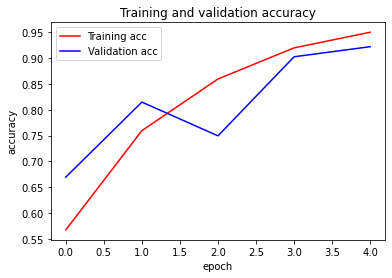

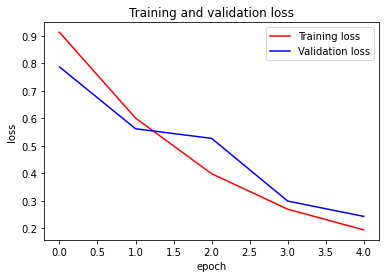

In [135]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label= 'Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

# Looking at the Activation Layers

In [114]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in model.layers]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [115]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 62, 62, 10)        280       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 10)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 9610)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 38444     
Total params: 38,724
Trainable params: 38,724
Non-trainable params: 0
_________________________________________________________________


(1, 62, 62, 10)


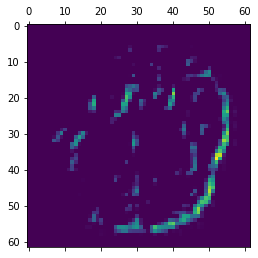

In [124]:
img_path = '../../src/data/train/NonDemented/nondem100.jpg'


img = image.load_img(img_path, target_size=(64, 64))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)


activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]  #The first activation layer 
print(first_layer_activation.shape)

# We slice the 9th channel and preview the results
plt.matshow(first_layer_activation[0, :, :, 9], cmap='viridis') # There are 10 different channels because our input was 10 for our first layer
plt.show()

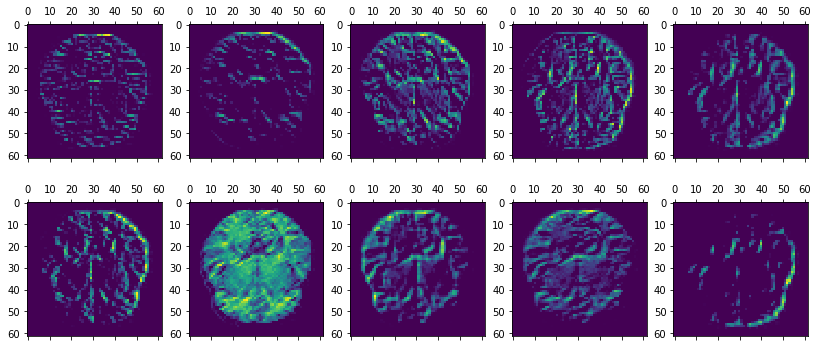

In [123]:
# All the different channels of the first imput layer. 
fig, axes = plt.subplots(2, 5, figsize=(14,6))
for i in range(10):
    row = i//5
    column = i%5
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

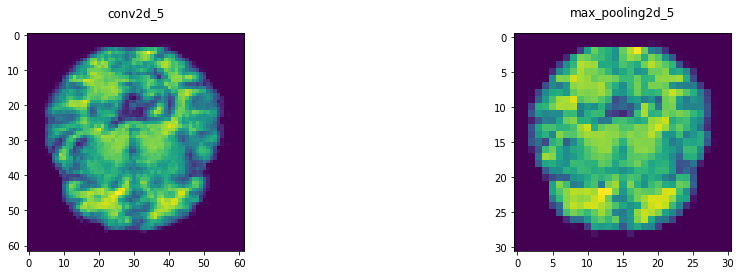

In [108]:
fig, axes = plt.subplots(1,2, figsize=(16,4))

layer_names = []
for layer in model.layers[:2]:
    layer_names.append(layer.name)

for i in range(2):
    column = i%4
    ax = axes[column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 2], cmap='viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])